In [57]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, classification_report, roc_auc_score
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

Importing Data

In [49]:
df = pd.read_csv("Fraud.csv", sep=",")
df.shape

(6362620, 11)

Check if any value is null

In [50]:
# Check if any data is null
df.isnull().any()

step              False
type              False
amount            False
nameOrig          False
oldbalanceOrg     False
newbalanceOrig    False
nameDest          False
oldbalanceDest    False
newbalanceDest    False
isFraud           False
isFlaggedFraud    False
dtype: bool

1. Count how many fraudulent/ flagged fraudulent transactions this dataset contains
2. Count how many unique customers/recipients this dataset contains

In [51]:
frauds_count = df['isFraud'].value_counts()
print(frauds_count)
frauds_flag_count = df['isFlaggedFraud'].value_counts()
print(frauds_flag_count)
count = df['nameOrig'].nunique()
print("Total unique Customers: ", count)
count = df['nameDest'].nunique()
print("Total unique Recipients:", count)


0    6354407
1       8213
Name: isFraud, dtype: int64
0    6362604
1         16
Name: isFlaggedFraud, dtype: int64
Total unique Customers:  6353307
Total unique Recipients: 2722362


Even with y_pred = [0, 0, ...., 0] accuracy = 99.87%

In [64]:
y_pred = np.full(shape = df.isFraud.shape, fill_value = 0)
print(accuracy_score(df.isFraud, y_pred))

0.9987091795518198


From Quicksight, we can see that only transactions of type CASH_OUT or TRANSFER contain fraudulent transaction
We can clean other rows having other types of transaction to explore further

In [65]:
roc_auc_score(df.isFraud, y_pred)


0.5

In [66]:
df_cleaned = df.loc[(df['type']=='CASH_OUT') | (df['type']=='TRANSFER')]

Convert transaction types -> unique integers

Convert Org Names and Dest Name -> unique integers (optional)

In [67]:
arr = df_cleaned.filter(like='name')
unique_names_df = pd.DataFrame(np.unique(arr, return_inverse=True)[1].reshape(arr.shape),
             index=arr.index,
             columns=arr.columns)
arr = df_cleaned.filter(like='type')
unique_type_df = pd.DataFrame(np.unique(arr, return_inverse=True)[1].reshape(arr.shape),
             index=arr.index,
             columns=arr.columns)

Preparing dataset prior to training

In [68]:
X = df_cleaned.drop(['isFlaggedFraud', 'isFraud', 'nameOrig', 'nameDest', 'type', 'step'], axis=1)
y = df_cleaned['isFraud'].values.reshape(-1,1)

Appending the converted names and types to features

In [69]:
# Add unique columns to X
X = X.join(unique_names_df)
X = X.join(unique_type_df)

In [70]:
print(X.shape)
print(y.shape)

(2770409, 8)
(2770409, 1)


In [71]:
X

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,nameOrig,nameDest,type
2,181.00,181.00,0.0,0.00,0.00,516496,2518756,1
3,181.00,181.00,0.0,21182.00,0.00,3006153,2242046,0
15,229133.94,15325.00,0.0,5083.00,51513.44,3116275,2388504,0
19,215310.30,705.00,0.0,22425.00,0.00,1136387,169525,1
24,311685.89,10835.00,0.0,6267.00,2719172.89,1667851,3163046,1
...,...,...,...,...,...,...,...,...
6362615,339682.13,339682.13,0.0,0.00,339682.13,2914695,2898485,0
6362616,6311409.28,6311409.28,0.0,0.00,0.00,896003,1493838,1
6362617,6311409.28,6311409.28,0.0,68488.84,6379898.11,275314,617716,0
6362618,850002.52,850002.52,0.0,0.00,0.00,1161800,1831033,1


# DECISION TREE

Splitting dataset to training and test data. Ratio 2:1

In [72]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, random_state=42, test_size=0.33)

Due to the imbalance of the training dataset -> create synthetic data samples

In [73]:
X_train['isFraud'] = y_train
negative = X_train[X_train.isFraud==0]
positive = X_train[X_train.isFraud==1]
pos_upsampled = resample(positive,
                        replace=True, # sample with replacement
                        n_samples=len(negative), # match number in majority class
                        random_state=27) # reproducible results
# combine majority and upsampled minority
upsampled = pd.concat([negative, pos_upsampled])
upsampled.isFraud.value_counts()

X_train = upsampled.drop(['isFraud'], axis=1)
y_train = upsampled['isFraud'].values.reshape(-1,1)
y_train = y_train.astype(int)

In [74]:
print(X_train.shape)
print(y_train.shape)

(3701416, 8)
(3701416, 1)


In [41]:
cont = True
while cont:
    my_tree = DecisionTreeClassifier(splitter='random', max_depth=10, max_features=5, max_leaf_nodes=15)
    my_tree.fit(X_train, y_train)

    y_pred = my_tree.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print()
    if cm[1][0]/cm[1][1] < 0.3 and my_tree.score(X_test, y_test) > 0.75:
        cont = False
        print(cm)
my_tree.score(X_test, y_test)


[[746140 165348]
 [   170   2577]]


0.8189546451404727

In [42]:
print(my_tree.get_depth())
print(my_tree.tree_.node_count)

9
29


/Users/ethanphan/Documents/Personal/de-challenge-2022/.venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


0.8189546451404727

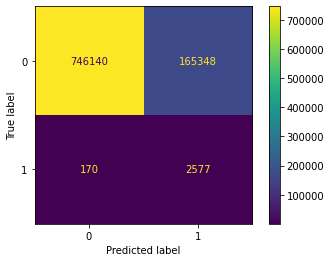

In [46]:
plot_confusion_matrix(my_tree, X_test, y_test)
my_tree.score(X_test, y_test)

In [47]:
text_representation = tree.export_text(my_tree, feature_names=my_tree.feature_names_in_.tolist())
print(text_representation)

|--- type <= 0.67
|   |--- amount <= 7123462.51
|   |   |--- oldbalanceDest <= 209166471.33
|   |   |   |--- amount <= 4797607.56
|   |   |   |   |--- amount <= 440011.62
|   |   |   |   |   |--- newbalanceOrig <= 252976.36
|   |   |   |   |   |   |--- oldbalanceOrg <= 222371.53
|   |   |   |   |   |   |   |--- oldbalanceOrg <= 45696.53
|   |   |   |   |   |   |   |   |--- amount <= 67534.92
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- amount >  67534.92
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- oldbalanceOrg >  45696.53
|   |   |   |   |   |   |   |   |--- newbalanceOrig <= 33220.99
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- newbalanceOrig >  33220.99
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- oldbalanceOrg >  222371.53
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- newbalanceOrig >  252976.36
|   |   |  

# Logistic Regression

#### Convert name string and type to unique values

In [82]:
arr = df.filter(like='name')
unique_names_df = pd.DataFrame(np.unique(arr, return_inverse=True)[1].reshape(arr.shape),
             index=arr.index,
             columns=arr.columns)
arr = df.filter(like='type')
unique_type_df = pd.DataFrame(np.unique(arr, return_inverse=True)[1].reshape(arr.shape),
             index=arr.index,
             columns=arr.columns)

In [87]:
X = df.drop(['isFlaggedFraud', 'isFraud', 'nameOrig', 'nameDest', 'type', 'step'], axis=1)
X = X.join(unique_names_df)
X = X.join(unique_type_df)

In [88]:
y = df['isFraud']

In [89]:
from imblearn.under_sampling import RandomUnderSampler
under_sampling = RandomUnderSampler(sampling_strategy=0.8)
X_res, y_res = under_sampling.fit_resample(X, y)

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [98]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(11087, 8)
(3696, 8)
(3696, 8)


In [100]:
from sklearn.linear_model import LogisticRegression

In [102]:
class_weight = {0: 4, 1: 5}
model = LogisticRegression(class_weight=class_weight)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))
print('accuracy', accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93      2050
           1       0.93      0.89      0.91      1646

    accuracy                           0.92      3696
   macro avg       0.93      0.92      0.92      3696
weighted avg       0.92      0.92      0.92      3696

accuracy 0.9242424242424242


In [ ]:
y_pred_test = model.predict(X_test)
print('accuracy', accuracy_score(y_test, y_pred_test))